In [1]:
%load_ext autoreload
%autoreload 2

import sys 
from os import getcwd, path
sys.path.append(path.dirname(getcwd()))
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
%matplotlib inline
import numpy as np
from utils import data
import cohorts

In [2]:
from utils.paper import *

In [3]:
from cohorts.plot import mann_whitney_plot
from cohorts.functions import missense_snv_count
from scipy.stats.stats import pearsonr

In [4]:
cohort = data.init_cohort()

{'dataframe_hash': -2899676230513618006,
 'provenance_file_summary': {u'cohorts': u'0.4.0+3.gda968fb',
                             u'isovar': u'0.0.6',
                             u'mhctools': u'0.3.0',
                             u'numpy': u'1.11.1',
                             u'pandas': u'0.18.1',
                             u'pyensembl': u'1.0.3',
                             u'scipy': u'0.18.1',
                             u'topiary': u'0.1.0',
                             u'varcode': u'0.5.10'}}


In [5]:
same_samples_index = ['0040','8728','1249','0471','1233','2849','6428','2389','9517','0522',
                      '6800','5338','2131','5122','1849','7729','9723','9881',
                      '6229','2278','1994','2937','7577','3529','5037']

In [6]:
def read_sig_csv(path):
    sigs = pd.read_csv(path, dtype={"Sample": str})
    sigs.index = sigs["Sample"]
    sigs = sigs.reindex(same_samples_index)
    return sigs

sigs_path = data.REPO_DATA_DIR + "/rizvi_cohort_signatures.csv"
sigs_df = read_sig_csv(sigs_path)

In [7]:
apobec_col_name = "APOBEC Signature"

# [#114](https://github.com/hammerlab/bladder-analyses/issues/114): Did APOBEC or Signature 5 (ERCC2) correlate with mutational burden?


In [8]:
missense_df = cohort.as_dataframe(on = {"missense_snv_count": missense_snv_count})

inner join with ensembl_coverage: 25 to 25 rows


In [9]:
sub_df = sigs_df[["Signature.5", "Signature.2", "Signature.13", "Sample"]]

In [10]:
def apobec_value(row):
    return np.linalg.norm([row["Signature.2"], row["Signature.13"]])

In [11]:
def ercc2_value(row):
    return row["Signature.5"]

In [12]:
mgd = pd.merge(missense_df, sub_df, left_on="patient_id", right_on="Sample")
mgd[apobec_col_name] = mgd.apply(apobec_value, axis=1)

### APOBEC signature vs. mutational burden (missense snv count)
Pearson correlation coefficient: 0.32
p value: 0.12

In [13]:
xticks = list(np.array(range(0,4,1)) * .2)
yticks = list(np.array(range(0, 15, 2)))

inner join with signatures: 25 to 25 rows


{{{apobec_vs_missense_pearsonr:n=25, Pearson r=0.40 p=0.048}}}
{{{apobec_vs_missense_plot}}}


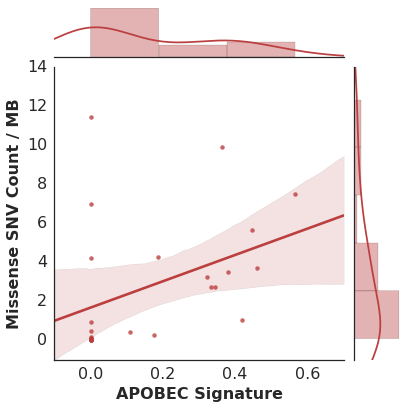

In [14]:
g = cohort.plot_correlation(on={apobec_col_name: apobec_value,
                          "Missense SNV Count / MB": missense_snv_count},
                      join_with="signatures",
                      stat_func=pearsonr,
                      show_stat_func=False,
                      plot_kwargs={"kind": "reg", "xlim": (-0.1,0.7),
                                       "ylim": (-1, 13)})
_ = g.plot.ax_joint.set_yticks(yticks)
_ = g.plot.ax_joint.set_xticks(xticks)

hyper_label_printer(pearsonr_formatter, label="apobec_vs_missense_pearsonr", results=g)
print "{{{apobec_vs_missense_plot}}}"

### ERCC2 signature vs. mutational burden (missense snv count)
Pearson correlation coefficient: -0.44
p value: 0.027

inner join with signatures: 25 to 25 rows


{{{ercc2_vs_missense_pearsonr:n=25, Pearson r=-0.28 p=0.17}}}
{{{ercc2_vs_missense_plot}}}


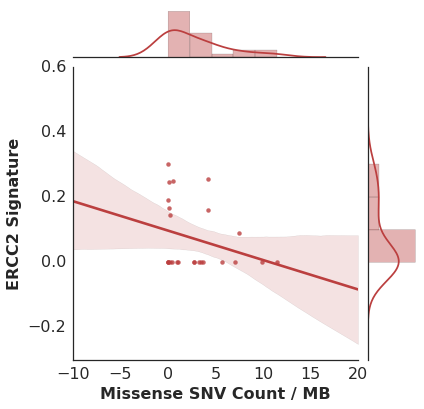

In [15]:
g = cohort.plot_correlation(on={"ERCC2 Signature": ercc2_value,
                          "Missense SNV Count / MB": missense_snv_count},
                      join_with="signatures",
                      stat_func=pearsonr,
                      show_stat_func=False,
                      plot_kwargs={"kind": "reg"})
                                        #, "xlim": (-0.1,0.7),
                    #                   "ylim": (-1, 13)})
#_ = g.plot.ax_joint.set_yticks(yticks)
#_ = g.plot.ax_joint.set_xticks(xticks)

hyper_label_printer(pearsonr_formatter, label="ercc2_vs_missense_pearsonr", results=g)
print "{{{ercc2_vs_missense_plot}}}"

# Signature correlation with benefit

In [16]:
def signatures_normalized_value(row, cohort, signature_df, signatures_list, 
                     **kwargs):
    """
    The behavior of np.linalg.norm is such that this will return the raw signature value if
    `signatures_list` is of length 1.
    If there is more than 1 signature specified, e.g. for APOBEC signatures [2, 13], returns their
    normalized value
    """
    patient_id = row["patient_id"]
    
    def normed_value(patient_id):
        if patient_id in signature_df.index:
            sig_values = [signature_df.at[patient_id, "Signature.{}".format(s)] for s in signatures_list]
            return np.linalg.norm(sig_values)
        return np.nan
    
    return normed_value(patient_id)    

## APOBEC: Signatures 2 & 13 from COSMIC

Mann-Whitney test: U=92.0, p-value=0.23387287738 (two-sided)
{{{apobec_signature_benefit_plot}}}
{{{apobec_signature_benefit_benefit:0.19 (range 0.00-0.56)}}}
{{{apobec_signature_benefit_no_benefit:0.00 (range 0.00-0.46)}}}
{{{apobec_signature_benefit_mw:n=25, Mann-Whitney p=0.23}}}


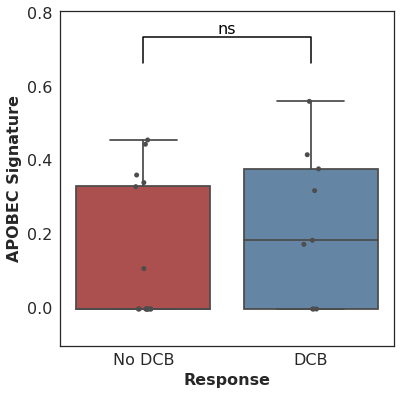

In [17]:
mann_whitney_hyper_label_printer(cohort.plot_benefit(on={apobec_col_name:
                                lambda row: signatures_normalized_value(row, cohort,
                                                     signatures_list=[2,13],
                                                     signature_df=sigs_df)}),
                                label="apobec_signature_benefit")
#results.plot.set_ylabel(apobec_col_name)

#print "{{{apobec_signature_benefit}}}"

In [18]:
from cohorts.survival import plot_kmf

OS


# no condition 13
# with condition 12


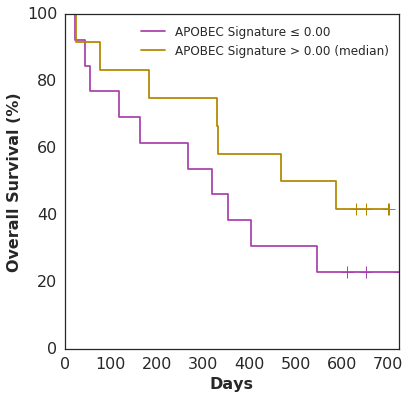

In [19]:
print("OS")
_ = cohort.plot_survival(on={"APOBEC Signature": lambda row: signatures_normalized_value(row, cohort,
                         signatures_list=[2,13], signature_df=sigs_df)}, how="os")
#                         legend_label = "APOBEC Signature")

OS
# no condition 13
# with condition 12


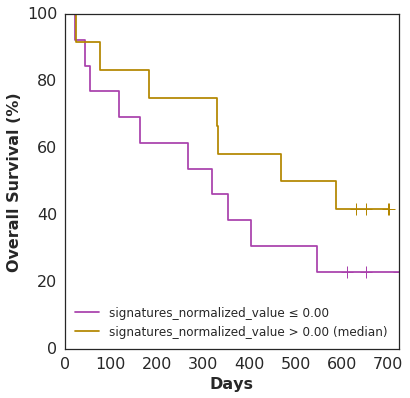

In [20]:
print("OS")
_ = cohort.plot_survival(on=signatures_normalized_value, 
                         signatures_list=[2,13], signature_df=sigs_df, how="os", 
                         legend_label = "APOBEC Signature")

PFS
# no condition 13
# with condition 12


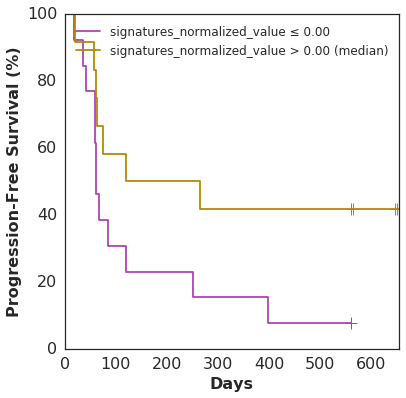

In [21]:
print("PFS")
_ = cohort.plot_survival(on=signatures_normalized_value, signatures_list=[2,13], signature_df=sigs_df, 
                         how="pfs",
                         legend_label = "APOBEC Signature")

## ERCC2 Signature

Mann-Whitney test: U=63.0, p-value=0.575488530703 (two-sided)


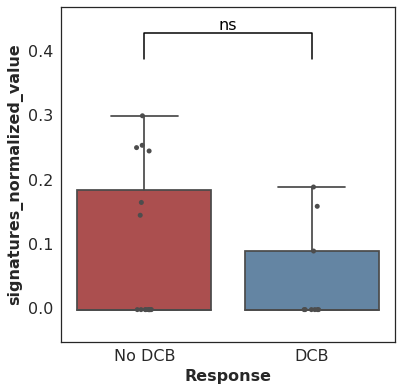

OS


# no condition 16
# with condition 9


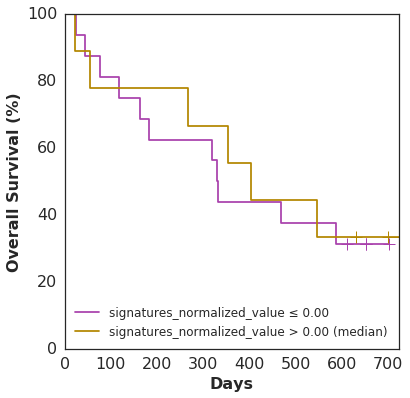

PFS


# no condition 16
# with condition 9


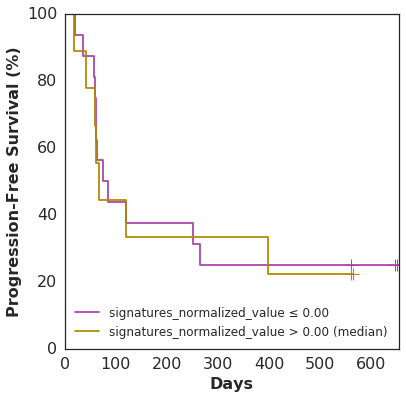

In [22]:
ercc2 = [5]
_ = cohort.plot_benefit(on=signatures_normalized_value, signatures_list=ercc2, signature_df=sigs_df)
plt.show()
print("OS")
_ = cohort.plot_survival(on=signatures_normalized_value, signatures_list=ercc2, signature_df=sigs_df, how="os")
plt.show()
print("PFS")
_ = cohort.plot_survival(on=signatures_normalized_value, signatures_list=ercc2, signature_df=sigs_df, how="pfs")
plt.show()

## Smoking Signature (Signature 4)

Mann-Whitney test: U=81.0, p-value=0.520761022121 (two-sided)


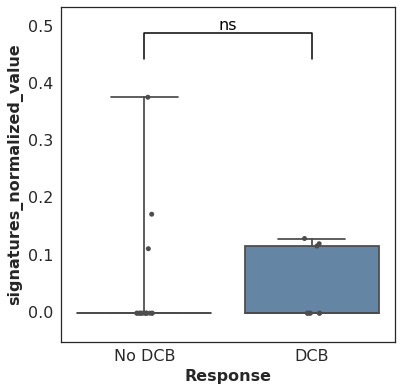

OS


# no condition 19
# with condition 6


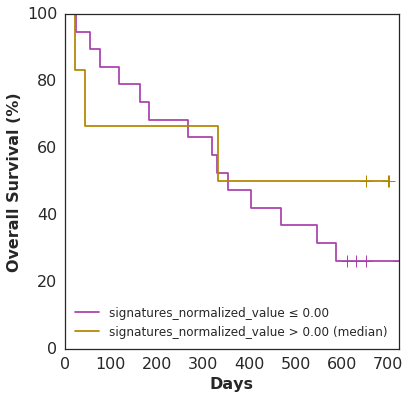

PFS


# no condition 19
# with condition 6


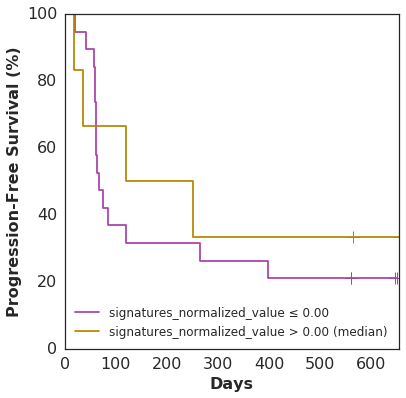

In [23]:
smoking = [4]
_ = cohort.plot_benefit(on=signatures_normalized_value, signatures_list=smoking, signature_df=sigs_df)

plt.show()
print("OS")
_ = cohort.plot_survival(on=signatures_normalized_value, signatures_list=smoking, signature_df=sigs_df, how="os")
plt.show()
print("PFS")
_ = cohort.plot_survival(on=signatures_normalized_value, signatures_list=smoking, signature_df=sigs_df, how="pfs")
plt.show()

## Heatmap of responders/non-responders and signature deconvolution
N.B. Samples 6229, 9723, 1233, 1994, 6428, and 9881 triggered a warning from deconstructSigs: 
> fewer than 50 mutations
i.e. the authors saw that sparse mutational profiles had high deconvolution error rates (discussion in [the paper](http://www.ncbi.nlm.nih.gov/pmc/articles/PMC4762164/))

/home/tavi/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


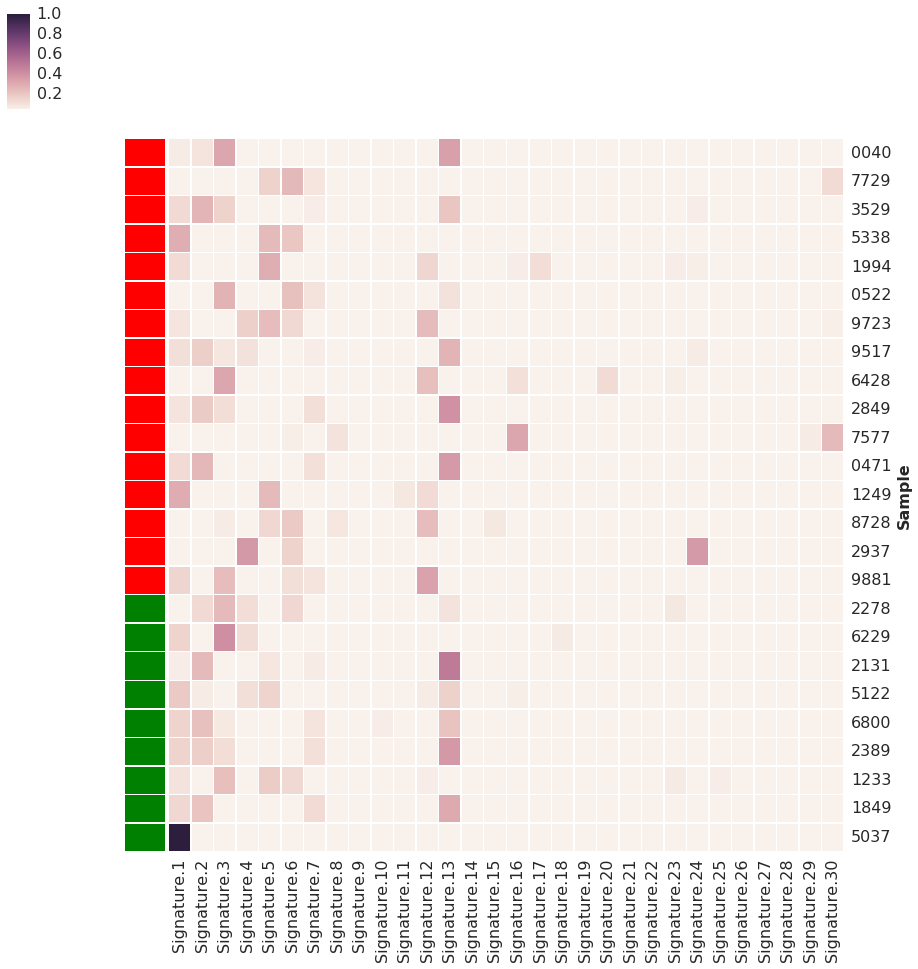

In [24]:
def create_clustermap(sigs, cohort, figure_path=None):
    df = sigs[sigs.columns[1:31]]
    cohort_df = cohort.as_dataframe()
    full_df = df.join(cohort_df.set_index('patient_id')["benefit"])
    full_df.sort(columns="benefit", inplace = True)
    cm = sb.clustermap(full_df[full_df.columns[:30]], 
                 row_colors = ['green' if b else 'red' for b in full_df["benefit"].values],
                  figsize=(15,15), vmin = 0.05, 
                            linewidths = 0.5, col_cluster = False, row_cluster = False)

    plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
    
    if figure_path is not None:
        plt.savefig(figure_path)

create_clustermap(sigs_df, cohort, "../../data/perPatient_Sigs.png")

### Compare cohort signatures vs. TCGA BLCA signatures  

In [25]:
tcga_sigs = pd.read_csv("../../data/tcga_ds_corrected.csv", header=None)

In [26]:
cohort_sigs = sigs_df[sigs_df.columns[1:31]]
tcga_for_cm = tcga_sigs[tcga_sigs.columns[1:]]
cohort_sigs.columns = tcga_for_cm.columns

cohort_sigs["in_cohort"] = cohort_sigs[cohort_sigs.columns[0]].apply(lambda x: True)
tcga_for_cm["in_cohort"] = tcga_for_cm[tcga_for_cm.columns[0]].apply(lambda x: False)
all_samples = cohort_sigs.append(tcga_for_cm)

/home/tavi/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [27]:
all_samples["cohort"] = pd.Series([True for x in range(len(cohort_sigs))] + 
                                  [False for x in range(len(tcga_for_cm))])

In [28]:
all_samples = all_samples.fillna(0)

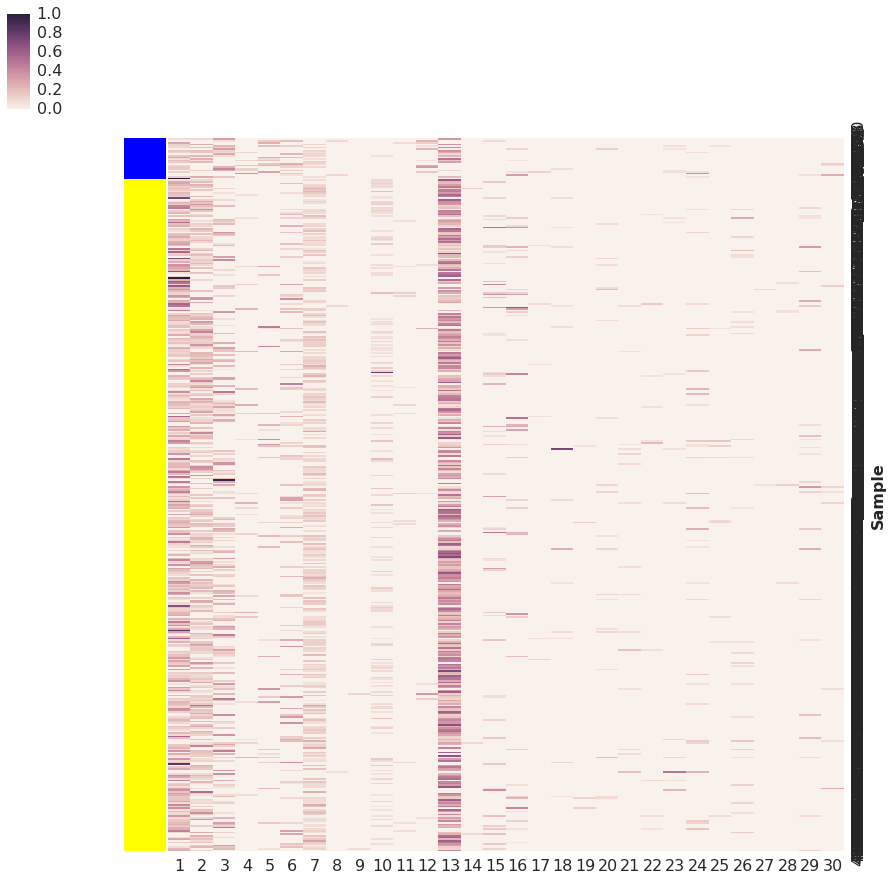

In [29]:
cm = sb.clustermap(all_samples[all_samples.columns[:30]], 
             row_colors = ['blue' if b else 'yellow' for b in all_samples["in_cohort"].values],
 figsize=(15,15), col_cluster = False, row_cluster = False)
#plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
#plt.yticks(rotation=0)
plt.savefig("../../data/tcga_blca_with_cohort_comparison_postbqsr_nofilter.png")
